# Practice Assignment — Power Law

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

## Power law distribution

The PDF of the Power law distribution is 

$$ p(x) = Cx^{-\alpha},$$ 

where $C$ is normalization constant and $\alpha>1$ is called as exponent of the distribution. 

From the lecture we know that 

$$C = \frac{\alpha - 1}{x_{\text{min}}^{-\alpha + 1}}.$$ 

In [2]:
def power_law_pdf(x, alpha, x_min):
    '''Calculate probability density function of Power law'''
    C = (alpha - 1) / x_min ** (1 - alpha)
    return C * x ** (-alpha)

Let us try to generate observations from Power law random variable.

### Task 1. Power law CDF (1 point)

The first step is to derive CDF of Powel law: $F(x) = P(X \leq x)$

$$F(x) = 1 - \int_{x}^\infty p(t) dt.$$

Take the integral, derive CDF analytically and write a function `power_law_cdf` with parameters `x`, `alpha` and `x_min`.

In [3]:
def power_law_cdf(x, alpha=3.5, x_min=1):
    '''Calculate cumulative distribution function of Power law'''
    return 1 - (x / x_min) ** (1 - alpha)

In [4]:
'''Check that CDF returns the correct output for several inputs'''
assert power_law_cdf(2, 2, 1) == 0.5
assert power_law_cdf(10, 2, 1) == 0.9

### Task 2. Power law PPF (1 point)

Let $X \sim \text{Power law}$. Next, define a random variable $R$, s.t. $R = F(X)$, so $R$ will be uniformly distributed on interval [0, 1] ([proof](https://en.wikipedia.org/wiki/Probability_integral_transform#Proof)). Good thing here is that we easily can generate uniformly distributed pseudorandom numbers. Let us find an expression for $x = F^{-1}(r)$, where $r$ is an observation from uniform distrubution on interval [0, 1]. 

Find an analytical form of $F^{-1}(r)$ and write a function `power_law_ppf` (percent point function) with parameters `r`, `alpha` and `x_min`. 

In [5]:
def power_law_ppf(r, alpha=3.5, x_min=1):
    '''Calculate percent point value of Power law'''
    return (1 - r) ** (1 / (1 - alpha)) * x_min

In [6]:
'''Check that PPF returns the correct output for several inputs'''
assert round(power_law_ppf(0.5, 2, 1), 10) == 2
assert round(power_law_ppf(0.9, 2, 1), 10) == 10

Finally, we can generate observation from Power law distribution as follows:
1. Generate observation from uniform distribution on interval [0, 1]
2. Calculate PPF value of given observation

In [7]:
def power_law_generate(n, alpha=3.5, x_min=1, random_seed=1):
    '''Generate observation from Power law distribution'''
    np.random.seed(random_seed)
    uni_sample = np.random.uniform(0, 1, n)
    return power_law_ppf(uni_sample, alpha, x_min)

Look at the histogram of the generated sample

In [8]:
alpha = 3.5
x_min = 1
x_train = power_law_generate(1000, alpha, x_min, 0)
x_space = np.linspace(1, 15, 100)

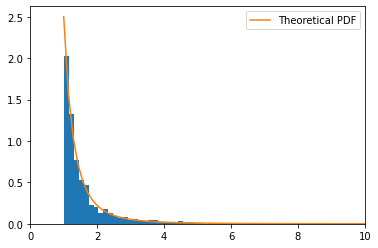

In [9]:
plt.hist(x_train, bins=200, density=True)
plt.plot(x_space, power_law_pdf(x_space, alpha, x_min), label='Theoretical PDF')
plt.legend()
plt.xlim(0, 10)
plt.show()

This is the same histogram in log-log scale

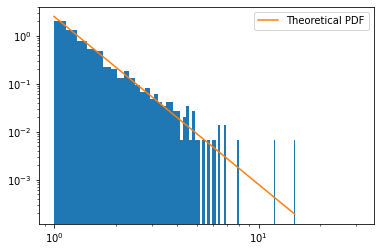

In [10]:
plt.hist(x_train, bins=200, density=True)
plt.plot(x_space, power_law_pdf(x_space, alpha, x_min), label='Theoretical PDF')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()

### Task 3. Estimation $\alpha$ with linear binning (2 points)

Given observations from Power law distribution, try to estimate $\alpha$. The easiest way is to draw an empirical PDF with linear binning in log-log scale and apply linear regression. For linear binning we fix each bin of empirical PDF in the same size.

Write a function `alpha_lin_bins` that returns an estimated $\alpha$.

*Hints:*
1. *Take the logarithm of both sides of PDF $p(x) = Cx^{-\alpha}$*
2. *To estimate $p(x)$ use an empirical PDF: `np.histogram(x, bins=1000, density=True)`*

In [11]:
def alpha_lin_bins(x_train):
    '''Estimate alpha using linear regression'''
    hist, bin_edges = np.histogram(x_train, bins=1000, density=True)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    idx = np.argwhere(hist > 0)
    x1 = np.log(bin_centers[idx].flatten())
    x2 = np.ones(len(idx))
    X = np.stack([x1, x2], axis=1)
    y = np.log(hist[idx])
    res = np.linalg.pinv(X) @ y
    coef = res[0][0]
    return -coef

In [12]:
'''Check estimations for different inputs'''
assert 2 < alpha_lin_bins(power_law_generate(20000, alpha=3.5)) < 5
assert 6 < alpha_lin_bins(power_law_generate(20000, alpha=10)) < 14

Let us draw the estimated PDF with linear binning.

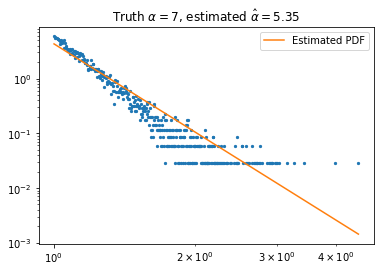

In [13]:
alpha, x_min = 7, 1
x_train = power_law_generate(10000, alpha, x_min)
hist, bin_edges = np.histogram(x_train, bins=1000, density=True)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
idx = hist > 0
plt.scatter(bin_centers[idx], hist[idx], s=5)
x_space = np.linspace(bin_centers[idx].min(), bin_centers[idx].max(), 100)
hat_alpha = alpha_lin_bins(x_train)
plt.plot(
    x_space, 
    power_law_pdf(x_space, hat_alpha, 1), 
    color='tab:orange',
    label='Estimated PDF')
plt.legend()
plt.title('Truth $\\alpha = {}$, estimated $\\hat\\alpha = {:.2f}$'.format(alpha, hat_alpha))
plt.xscale('log')
plt.yscale('log')
plt.show()

### Task 4. Estimation $\alpha$ with logarithmic binning (2 points)

As we see the estimation with linear binning is noticeably inaccurate. Why do you think? _Hint: fat tail_. Let us try to apply logarithmic binning. For logarithmic binning we let the bin sizes increase with the value, making sure that each bin has a comparable number of observations.

Write a function `alpha_log_bins` that returns an estimated $\alpha$.

*Hint: use `np.logspace(0, np.log10(x_train.max()), 20)` to generate an increasing logarithmic sequence of 20 bins.*

In [14]:
def alpha_log_bins(x_train):
    '''Estimate alpha using linear regression'''
    hist, bin_edges = np.histogram(x_train, bins=np.logspace(0, np.log10(x_train.max()), 20), density=True)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    idx = np.argwhere(hist > 0)
    x1 = np.log(bin_centers[idx].flatten())
    x2 = np.ones(len(idx))
    X = np.stack([x1, x2], axis=1)
    y = np.log(hist[idx])
    res = np.linalg.pinv(X) @ y
    coef = res[0][0]
    return -coef

In [15]:
'''Check estimations for different inputs'''
assert 3.4 < alpha_log_bins(power_law_generate(20000, alpha=3.5)) < 3.6
assert 9.9 < alpha_log_bins(power_law_generate(20000, alpha=10)) < 10.1

Let us draw the estimated PDF with log binning.

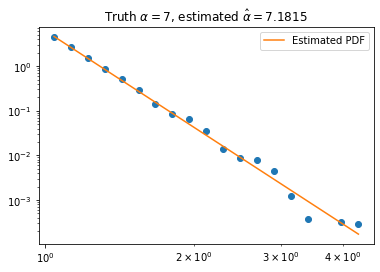

In [16]:
bins = np.logspace(0, np.log10(x_train.max()), 20)
hist, bin_edges = np.histogram(x_train, bins=bins, density=True)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
hat_alpha = alpha_log_bins(x_train)
idx = hist > 0
plt.scatter(bin_centers[idx], hist[idx])
x_space = np.linspace(bin_centers[idx].min(), bin_centers[idx].max(), 100)
plt.plot(
    x_space, 
    power_law_pdf(x_space, hat_alpha, 1), 
    color='tab:orange',
    label='Estimated PDF')
plt.legend()
plt.title('Truth $\\alpha = {}$, estimated $\\hat\\alpha = {:.4f}$'.format(alpha, hat_alpha))
plt.xscale('log')
plt.yscale('log')
plt.show()

## NetworkX quick start

NetworkX is a Python package that we will use for network analysis. First of all, let us check that we use the version 2.5 of NetworkX.

In [17]:
import networkx as nx
assert nx.__version__ == '2.5'

If you have another version, please reinstall the package 

```
pip uninstall networkx
pip install networkx==2.5
```

Next, create an empty graph.

In [18]:
G = nx.Graph()

We can create edges one-by-one. For example, create nodes 1, 2 and edge between them. Repeat for nodes 2, 3.

In [19]:
G.add_edge(1, 2)
G.add_edge(2, 3)

Or we can create edges from list of edges. Create edges (2, 4), (2, 5) and (2, 6).

In [20]:
G.add_edges_from([(2, 4), (2, 5), (2, 6)])

Let us draw the graph

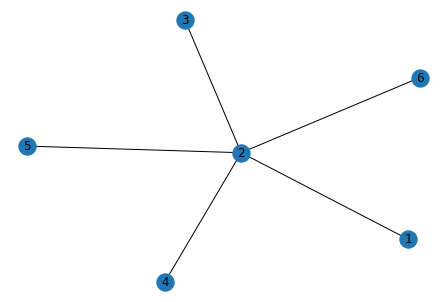

In [21]:
nx.draw(G, with_labels=True)

We can get a list of edges and nodes

In [22]:
print(G.nodes)

[1, 2, 3, 4, 5, 6]


In [23]:
print(G.edges)

[(1, 2), (2, 3), (2, 4), (2, 5), (2, 6)]


We can get nodes degree

In [24]:
# List of pairs of the form (node: degree)
G.degree

DegreeView({1: 1, 2: 5, 3: 1, 4: 1, 5: 1, 6: 1})

If you want to clear the graph use

In [25]:
G.clear()

Let us read a graph from a file with a list of edges. Create a new file, and then read it via NetworkX.

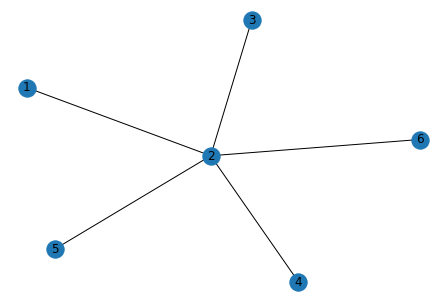

In [26]:
with open('edges.txt', 'w') as edges_file:
    edges_file.writelines(
        '''
        1 2
        2 3
        2 4
        2 5
        2 6
        '''
    )

G = nx.read_edgelist('edges.txt')
nx.draw(G, with_labels=True)

Also we can read an adjacency matrix using numpy

In [27]:
with open('adjacency.txt', 'w') as edges_file:
    edges_file.writelines(
        '''
        0 1 0 0 0 0
        1 0 1 1 1 1
        0 1 0 0 0 0
        0 1 0 0 0 0
        0 1 0 0 0 0
        0 1 0 0 0 0
        '''
    )

A = np.loadtxt('adjacency.txt')
print(A)

[[0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


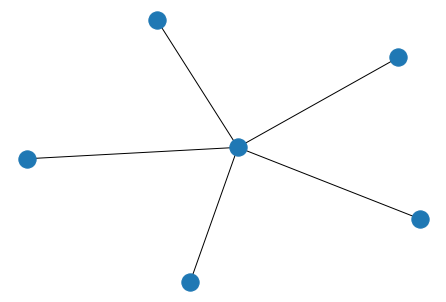

In [28]:
G = nx.from_numpy_array(A)
nx.draw(G)

We can compute some graph statistics

In [29]:
nx.radius(G)

1

In [30]:
nx.diameter(G)

2

In [31]:
nx.average_shortest_path_length(G)

1.6666666666666667

You can read about other features of NetworkX here https://networkx.github.io/documentation/

## Fitting Real Distributions

Let us consider [fb_Princeton.txt](https://raw.githubusercontent.com/vpozdnyakov/network_science_assignments/master/assignment_power_law/fb_Princeton.txt): Princeton Facebook friendship network.

### Task 5. Descriptive statistics of a network (2 points)

Print the descriptive statistics of the network: number of nodes, number of edges, number of connected components, radius, diameter, degree distribution.

Write a function `desc_stats` that takes in input `url` to file with list of edges and the number of first line `first_line` with an edge. For example, for the file [fb_Princeton.txt](https://raw.githubusercontent.com/vpozdnyakov/network_science_assignments/master/assignment_power_law/fb_Princeton.txt) `first_line=5`. The function should return a dictionary with keys:
* `n_nodes`: number of nodes
* `n_edges`: number of edges
* `n_connected_components`: number of connected components
* `radius`: radius of the giant component
* `diameter`: diameter of the giant component
* `degree_sequence`: np.array of node degrees of the giant component

*Hints:* 
1. *To load the network use `np.loadtxt(url)`*
2. *To create a subgraph use `G.subgraph(nodes).copy()`*
3. *To speed up the calculation of a radius and diameter, use the stochastic estimation: take into account only random 5% eccentricities*

In [32]:
def desc_stats(url, first_line=1, random_seed=1):
    '''Calculate descriptive statistics of a network.'''
    A = np.loadtxt(url)
    G = nx.from_edgelist(A)
    result = {}
    result['n_nodes'] = len(G.nodes)
    result['n_edges'] = len(G.edges)
    result['n_connected_components'] = nx.number_connected_components(G)
    giant = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0]).copy()
    nodes = list(giant.nodes)
    np.random.seed(random_seed)
    random_nodes = np.random.choice(nodes, size=round(0.05 * len(nodes)), replace=False)
    eccentricity = [v for k,v in nx.eccentricity(giant, v=random_nodes).items()]
    result['radius'] = min(eccentricity)
    result['diameter'] = max(eccentricity)
    result['degree_sequence'] = np.array([d for n, d in giant.degree()])
    return result

In [33]:
'''Check statistics of the network'''
url = 'https://raw.githubusercontent.com/vpozdnyakov/network_science_assignments/master/assignment_power_law/fb_Princeton.txt'
fb_stats = desc_stats(url, 5)
assert fb_stats['n_nodes'] == 6596

Let us draw the node degree distribution.

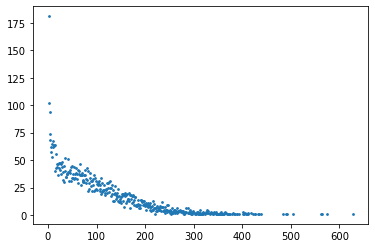

In [34]:
hist = np.bincount(fb_stats['degree_sequence'])
idx = np.argwhere(hist > 0)
plt.scatter(idx, hist[idx], s=3)
plt.show()

### Task 6. Maximum likelihood estimation of Power law (2 points)

Let us estimate $\alpha$ and $x_\min$ of Princeton network using maximum likelihood. The algorithm consists of:
1. Fix $x_\min$ as a minimal node degree
2. Calculate $\alpha$ via maximum likelihood estimation using fixed $x_\min$
3. Calculate Kolmogorov-Smirnov test
4. Fix $x_\min$ as the next node degree
5. Repeat 2-4 by scanning all possible $x_\min$ and find the best $\alpha$ and $x_\min$ with respect to Kolmogorov-Smirnov test

Write a function `ml_power_law_params` that takes as input node degree sequence `degree_sequence` and returns a tuple of two values: the best $\alpha$ and $x_\min$.

*Hints:*
1. *Do not forget to drop node degrees that less than $x_\min$ in each iteration*
2. *To calculate Kolmogorov-Smirnov distance use `scipy.stats.kstest`*
3. *Look at details in http://networksciencebook.com/*

In [35]:
def ml_power_law_params(degree_sequence):
    '''Estimate alpha and x_min via maximum lokelihood'''
    best_alpha, best_x_min = None, None
    best_kstest = None
    degree_sequence = np.sort(np.array(degree_sequence))
    x_mins = range(1, int(degree_sequence[-1]))
    for x_min in x_mins:
        degrees = degree_sequence[degree_sequence >= x_min]
        if len(degrees) < 1:
            break
        alpha = 1 + degrees.size * (np.sum(np.log(degrees)) - degrees.size * np.log(x_min)) ** -1
        kstest = stats.kstest(degrees, lambda x: power_law_cdf(x, alpha=alpha, x_min=x_min)).statistic
        if best_kstest is None or kstest < best_kstest:
            best_kstest = kstest
            best_alpha = alpha
            best_x_min = x_min
    return best_alpha, best_x_min

In [36]:
'''Check the estimation of Power law parameters'''
alpha, x_min = 3.5, 1
hat_alpha, hat_x_min = ml_power_law_params(power_law_generate(20000, alpha, x_min))
assert round(hat_alpha, 1) == alpha and round(hat_x_min, 1) == x_min
alpha, x_min = 7, 1
hat_alpha, hat_x_min = ml_power_law_params(power_law_generate(20000, alpha, x_min))
assert round(hat_alpha, 1) == alpha and round(hat_x_min, 1) == x_min
alpha, x_min = 10, 3
hat_alpha, hat_x_min = ml_power_law_params(power_law_generate(20000, alpha, x_min))
assert round(hat_alpha, 1) == alpha and round(hat_x_min, 1) == x_min

Let us draw the estimated PDF.

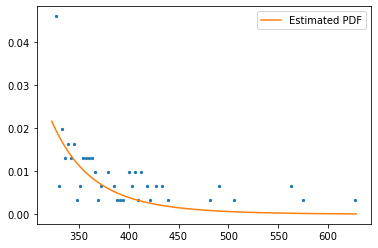

In [37]:
degree_sequence = fb_stats['degree_sequence']
best_alpha, best_x_min = ml_power_law_params(degree_sequence)

hist, bin_edges = np.histogram(
    degree_sequence[degree_sequence > best_x_min], 
    bins=100, 
    density=True)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
idx = hist > 0
plt.scatter(bin_centers[idx], hist[idx], s=5)
x_space = np.linspace(best_x_min, fb_stats['degree_sequence'].max(), 100)
plt.plot(
    x_space, 
    power_law_pdf(x_space, best_alpha, best_x_min), 
    color='tab:orange', 
    label='Estimated PDF')
plt.legend()
plt.show()